# MitoCheck

In [1]:
## Ipython magic commands...! 

%matplotlib inline
%load_ext rpy2.ipython

In [2]:
### All the packages we need:
from Traj_creator import Traj_data
from TCA import *
from Mitocheck_Read import MitoCheck_Read
from Randomforest import RandomForest_Autotunner,plot_matrix,Measure,check_rotate
from auxilary_function import final_classif_HMM,MitoseClassif,EmissionMat,prep_for_R

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os.path
import cPickle as pkl

In [3]:
## names for the variables
y_name_3state="Type"         #variable name of the labels in the training set
classif_Mitose="MitoseOrNot" #variable name for the mitosis variable
classif_3state="3state"      #variable name for the classifier we wish to test
classif_final="Pred_fusion"  #variable name for the fusion of these two classifiers
num_str="0015" 
%Rpush classif_final

In [4]:
if os.path.isfile("H2B_N_F_0.csv"):
    print "The file existed so I loaded it."
    H2B_N_F_0 = Traj_data(file_name="H2B_N_F_0.csv",pkl_traj_file="./Pkl_file") 
    H2B_N_F_0.caract="Normalized by dividing by first element"

else:    
    H2B_N_F_0=Traj_data()#(pkl_traj_file="/home/pubuntu/Documents/InternWork2/Pkl_file") 

    H2B_N_F_0.extracting(num_str,"both_channels_0015.hdf5",'primary') 
    ## Extracting the hdf5 file for the primary channel (H2b)
    
#    H2B_N_.add_error() ## We had it so that the data won't have to do 0/0

    H2B_N_F_0.Add_traj(normalize=True,all_traj=False,average=False,diff=False)## ,num_traj=10) ## (you can reduce the number of traj)
    ## Adding Alice's work on tracking to have trajectories

    file_loc="0015_PCNA.xml"

    H2B_N_F_0.label_finder(file_loc) 
    ## Finding associated labels by minimizing distance by click and distance of cell

    H2B_N_F_0.renaming_and_merge() 
    ## renaming the labels to have G1=="1", S=="S", G2=="2" and M=="M" 
    #This procedure may take a long time.

    H2B_N_F_0.data.to_csv('H2B_N_F_0.csv',index=False,header=True)

    

if H2B_N_F_0.Var_missing[0] in H2B_N_F_0.train.columns:
    H2B_N_F_0.missing_features_train()
if H2B_N_F_0.Var_missing[0] in H2B_N_F_0.data.columns:
    H2B_N_F_0.missing_features_data()

    
    

The file existed so I loaded it.
Traj_data built
Reader constructed
Updated member Group_of_traj


/home/pubuntu/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:3006: DtypeWarning: Columns (245) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [21]:
MitoCheck = MitoCheck_Read()

if MitoCheck.Var_missing[0] in MitoCheck.data.columns:
    MitoCheck.missing_features()


MitoCheck_Read()
Updated member Group_of_traj


In [7]:
MitoCheck=_free_return

In [13]:
_free_return=MitoCheck

In [31]:
MitoCheck.data.shape

(18557, 240)

In [16]:
_free_return.data.shape

(35881, 242)

# Preparing the classifier and prediction:

## Mitose or Not?

### Training: 


 We first load the unnormalized data: 

The file existed so I loaded it.
Traj_data built
Reader constructed
Updated member Group_of_traj

 We train a classifier for mitosis or not: 

Reader constructed
Processing time: 275.990085 in sec


/home/pubuntu/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:3066: DtypeWarning: Columns (245) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


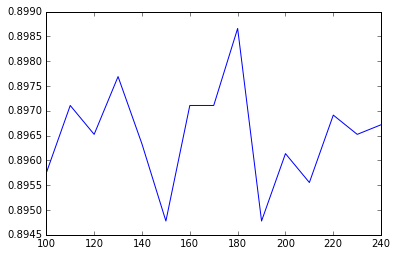

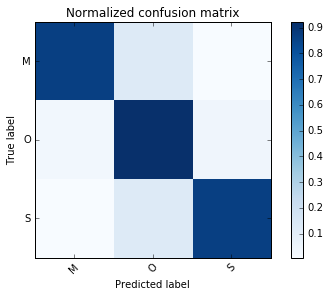

Updated member Group_of_traj
Updated member Group_of_traj

 A bit of statistics on the overall predictions: 

Frequency of predicted values for the Mitosis or not classifier: 

S    15039
O    13890
M      885
Name: MitoseOrNot, dtype: int64

 We were however not able to predict 0 instances because of missing values
Updated member Group_of_traj


In [8]:
H2B_N_F_0,model_1=MitoseClassif(H2B_N_F_0,
                                y_name_3state=y_name_3state,
                               classif_Mitose=classif_Mitose,
                               num_str=num_str)

### Predicting in MitoCheck dataset

In [30]:
MitoCheck.data=MitoCheck.data.replace([np.inf, -np.inf], np.nan)

instances_to_keep_Mito=MitoCheck.data.dropna(axis=0, how='any').index

print "Size of the data set: %d" %MitoCheck.data.shape[0]
print "Number of dropped values: %d" %(MitoCheck.data.shape[0]-len(instances_to_keep_Mito))

MitoCheck.data.ix[instances_to_keep_Mito,classif_Mitose]=model_1.predict(MitoCheck.data.ix[instances_to_keep_Mito,model_1.names_to_give])

print "A bit of descriptive statistic about the prediction on MitoCheck: \n"
MitoCheck.data[classif_Mitose].value_counts()

Size of the data set: 18557
Number of dropped values: 55


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

## 3 State classifier

Updated member Group_of_traj
training dataset: 

S    217
1    199
2     56
M     36
Name: Type, dtype: int64
Processing time: 24.404545 in sec


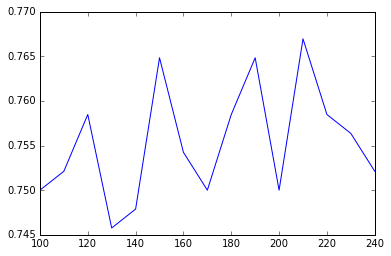

We now have a classifier with n=210, with an expected accuracy of 0.767 for the normalized data. 



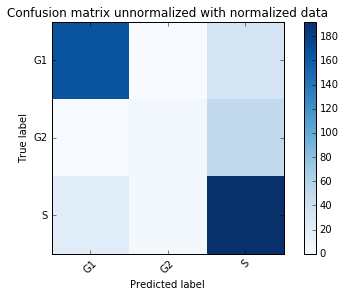

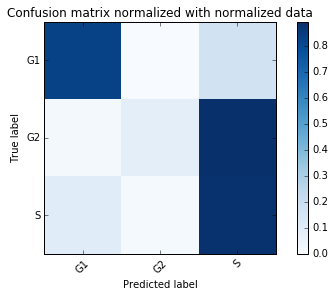

Frequency of predicted values for the 3 state classifier: 

1    16064
S    12382
2     1368
Name: 3state, dtype: int64


In [11]:
## classifier number 1

###
kfold=3

instances_to_keep=pd.notnull(H2B_N_F_0.data.traj)

H2B_N_F_0.data=H2B_N_F_0.data.ix[instances_to_keep,H2B_N_F_0.data.columns]

instances_to_change=H2B_N_F_0.data["Type"]!="M"

H2B_N_F_0.update()

print "training dataset: \n"
print H2B_N_F_0.train["Type"].value_counts()

values=[100 + i*10 for i in range(15)]
model_n_m=RandomForest_Autotunner(values)

model_n_m.tunning(H2B_N_F_0.train.ix[instances_to_change,H2B_N_F_0.names],H2B_N_F_0.train.ix[instances_to_change,"Type"],kfold,plot=True,fit_new_model=True)
plt.show()

i_=np.argmax(model_n_m.MSE)
n_tree=values[i_]
print "We now have a classifier with n=%d, with an expected accuracy of %5.3f for the normalized data. \n" %(n_tree,max(model_n_m.MSE))


plot_matrix(model_n_m.cm,title="Confusion matrix unnormalized with normalized data",names=["G1","G2","S"])
plt.show()
model_n_m.cm_normalized = model_n_m.cm.astype('float') / model_n_m.cm.sum(axis=1)[:, np.newaxis]
plot_matrix(model_n_m.cm_normalized,title="Confusion matrix normalized with normalized data",names=["G1","G2","S"])
plt.show() 

index_no_missing=H2B_N_F_0.data[H2B_N_F_0.names].dropna(axis=0, how='any').index
H2B_N_F_0.data.ix[index_no_missing,"3state"]=model_n_m.predict(H2B_N_F_0.data.ix[index_no_missing,H2B_N_F_0.names])
print "Frequency of predicted values for the 3 state classifier: \n"
print H2B_N_F_0.data.ix[index_no_missing,classif_3state].value_counts()

### Predicting in the Mitocheck

We have to normalize MitoCheck first

In [22]:
#MitoCheck.error_names=[el for el in MitoCheck.error_names if el in MitoCheck.data.columns]


MitoCheck.Normalize(division=True,average=False)  

MitoCheck.data=MitoCheck.data.replace([np.inf, -np.inf], np.nan)

Mito=MitoCheck.data.dropna(axis=0, how='any')

Mito[classif_3state]=model_n_m.predict(Mito[H2B_N_F_0.names])

print "A bit of descriptive statistic about the prediction on MitoCheck: \n"
print Mito[classif_3state].value_counts()

##MitoCheck.data=MitoCheck.data.join(Mito[classif_3state])


Because of missing values I adjusted it, in the case X_t/X_0
A bit of descriptive statistic about the prediction on MitoCheck: 

1    16170
S     1790
2      542
Name: 3state, dtype: int64


/home/pubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [27]:
MitoCheck.data.join(Mito[[classif_3state]])

,ch_acd,ch_area_ratio,ch_cc,ch_max_val_0,ch_max_val_1,ch_max_val_2,ch_mean_area,ch_rugosity,ch_thresh_cc,ch_variance_area,...,princ_gyration_y,roisize,skewness_x,skewness_y,line_id,y_hdf5,Well,traj,Frame,3state
82,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1,1.000000,...,1.000000,1.000000,1.000000,1.000000,82,0,063,79,1,1
88,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1,1.000000,...,1.000000,1.000000,1.000000,1.000000,88,0,063,80,1,1
90,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1,1.000000,...,1.000000,1.000000,1.000000,1.000000,90,0,074,87,1,1
91,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1,1.000000,...,1.000000,1.000000,1.000000,1.000000,91,0,074,88,1,1
95,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1,1.000000,...,1.000000,1.000000,1.000000,1.000000,95,7,352,66,1,1
96,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1,1.000000,...,1.000000,1.000000,1.000000,1.000000,96,7,352,67,1,1
106,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1,1.000000,...,1.000000,1.000000,1.000000,1.000000,106,0,063,82,1,1
117,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1,1.000000,...,1.000000,1.000000,1.000000,1.000000,117,0,304,63,1,1
146,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1,1.000000,...,1.000000,1.000000,1.000000,1.000000,146,7,304,65,2,1
148,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1,1.000000,...,1.000000,1.000000,1.000000,1.000000,148,7,304,66,2,1


In [29]:
print MitoCheck.data.shape
print MitoCheck.data.join(Mito[[classif_3state]]).shape
Mito
MitoCheck.data.classif_Mitose

(18557, 240)
(35881, 241)


AttributeError: 'DataFrame' object has no attribute 'classif_Mitose'

In [26]:
MitoCheck.data

,ch_acd,ch_area_ratio,ch_cc,ch_max_val_0,ch_max_val_1,ch_max_val_2,ch_mean_area,ch_rugosity,ch_thresh_cc,ch_variance_area,...,princ_gyration_x,princ_gyration_y,roisize,skewness_x,skewness_y,line_id,y_hdf5,Well,traj,Frame
178,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,178,0,015,135,1
310,0.980595,0.988121,2.0,1.006795,1.002157,1.002157,1.333333,1.000000,1,3.000000,...,1.021276,0.978422,1.136752,0.983492,0.990518,310,0,015,135,2
447,0.999424,0.994259,2.0,1.003114,1.003763,1.001562,1.333333,1.000000,1,1.666667,...,1.016437,0.985133,1.290598,1.006172,0.987810,447,0,015,135,3
589,1.013799,0.995935,1.5,1.007741,1.001641,0.999400,1.666667,1.000000,1,5.000000,...,1.020578,0.980729,1.267806,0.984057,1.001812,589,0,015,135,4
737,0.984582,0.995320,1.5,1.002779,1.003510,0.999276,1.500000,1.000000,1,1.250000,...,1.050107,0.957349,1.341880,1.008112,1.009920,737,0,015,135,5
892,1.012729,1.005781,1.0,0.998539,0.999267,0.999267,1.000000,1.000000,1,1.000000,...,1.035374,0.969020,1.347578,1.016090,1.022320,892,0,015,135,6
1049,0.985150,0.991016,3.0,1.002305,1.003154,1.001156,1.200000,1.009901,1,1.640000,...,1.007893,0.993170,1.421652,0.992903,0.986635,1049,0,015,135,7
1207,0.996840,0.999595,2.5,0.998530,1.001367,1.001367,1.000000,1.000000,1,1.000000,...,1.004445,0.998402,1.350427,1.018795,0.990816,1207,0,015,135,8
1370,0.974440,0.997610,2.5,0.998196,1.001032,1.001032,1.000000,1.000000,1,1.000000,...,1.015057,0.987736,1.467236,1.011020,1.008683,1370,0,015,135,9
1538,0.952716,0.988251,3.0,1.000127,1.001032,1.001032,1.066667,1.009524,1,1.160000,...,1.009687,0.991191,1.467236,1.000266,0.981845,1538,0,015,135,10


## Preparing the data


 We compute the emission state probability matrix from the confusion matrix for the first classifier: 



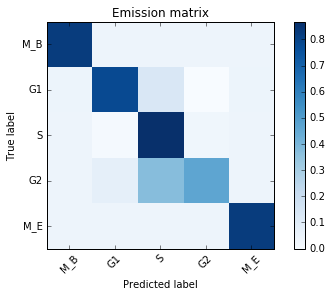

In [42]:
EmissionMat_=EmissionMat(model_1,model_n_m)

In [13]:
H2B_N_F_0,data=prep_for_R(H2B_N_F_0,
           classif_3state=classif_3state,
           classif_final=classif_final,
           classif_Mitose=classif_Mitose,
           num_str=num_str)


 We prioritize our predictor of mitosis events before the 3 state classfier giving 
 us a four state classifier. 

Frequency of predicted values for the 4 state classifier: 

1    15039
S    12510
2     1375
M      890
Name: Pred_fusion, dtype: int64
Updated member Group_of_traj


In [53]:
execfile('auxilary_function.py')

MitoCheck,data_Mito=prep_for_R(MitoCheck,
           classif_3state=classif_3state,
           classif_final=classif_final,
           classif_Mitose=classif_Mitose,
           num_str=num_str)


 We prioritize our predictor of mitosis events before the 3 state classfier giving 
 us a four state classifier. 

Frequency of predicted values for the 4 state classifier: 

> /home/pubuntu/Documents/InternWork2/auxilary_function.py(143)prep_for_R()
-> print Mito.value_counts()
(Pdb) Mito.head()
178    1
310    1
310    1
447    1
447    1
Name: Pred_fusion, dtype: object
(Pdb) len(Mito)
35857
(Pdb) Mito.shape
(35857,)
(Pdb) obj_norm.shape
*** AttributeError: MitoCheck_Read instance has no attribute 'shape'
(Pdb) obj_norm.data.shape
(35881, 243)
(Pdb) q


BdbQuit: 

In [54]:
MitoCheck.data.shape

(35881, 243)